## Initialize notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import euclidean_distances
from geopy.distance import geodesic

pd.set_option('display.max_columns', None)
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

## Load data

In [2]:
df_hotels = pd.read_csv('hotel_inventory_data-20181217.csv')
df_hotels.head()

,hotel_id,avg_rate,distance,star_rating,user_rating,lat,lng
0,0,215.67,1.619861,4.0,4.0,40.693553,-73.988339
1,1,165.67,0.685884,3.0,4.0,40.718508,-73.995305
2,2,109.65,1.604060,3.5,4.0,40.696405,-73.984344
3,3,159.21,0.244390,4.0,4.0,40.715570,-74.008901
4,4,253.75,0.875482,5.0,NaN,40.725479,-74.005382


In [3]:
df_hotels.describe()

,hotel_id,avg_rate,distance,star_rating,user_rating,lat,lng
count,98.000000,98.000000,98.000000,98.000000,80.000000,98.000000,98.000000
mean,48.500000,190.766837,0.966523,3.698980,4.131250,40.716787,-74.002116
std,28.434134,76.124253,0.743097,0.724177,0.419039,0.013716,0.013221
min,0.000000,90.000000,0.115349,2.000000,2.500000,40.689554,-74.040882
25%,24.250000,146.750000,0.497890,3.000000,4.000000,40.708927,-74.009144
50%,48.500000,173.800000,0.698184,4.000000,4.000000,40.716517,-74.004824
75%,72.750000,228.167500,1.172286,4.000000,4.500000,40.721712,-73.992609
max,97.000000,650.000000,3.761915,5.000000,5.000000,40.764491,-73.969347


## Exploratory data analysis

Text(0.5, 1.0, 'user_rating')

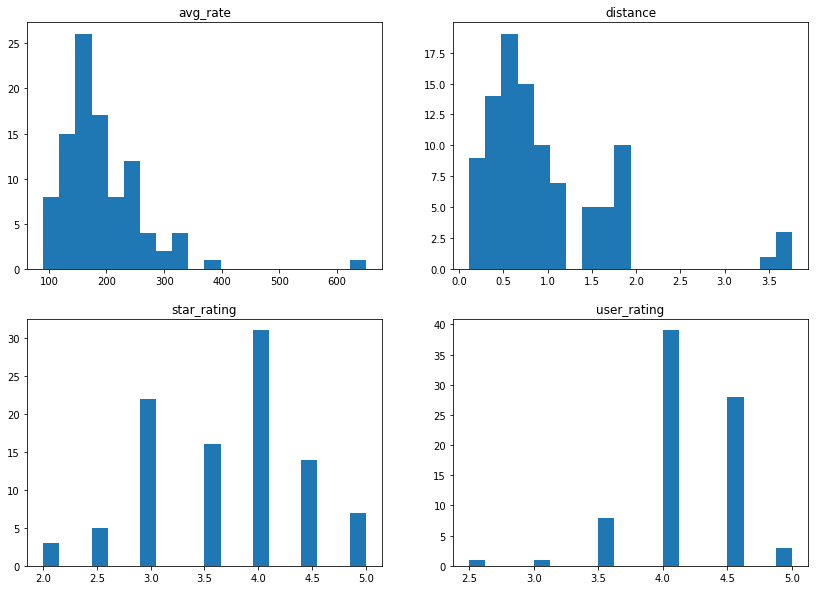

In [5]:
plt.figure(figsize=(14, 10))
plt.subplot(221)
plt.hist(df_hotels['avg_rate'].values, bins=20)
plt.title('avg_rate')
plt.subplot(222)
plt.hist(df_hotels['distance'].values, bins=20)
plt.title('distance')
plt.subplot(223)
plt.hist(df_hotels['star_rating'].values, bins=20)
plt.title('star_rating')
plt.subplot(224)
plt.hist(df_hotels['user_rating'].values, bins=20)
plt.title('user_rating')

Text(0, 0.5, 'avg_rate')

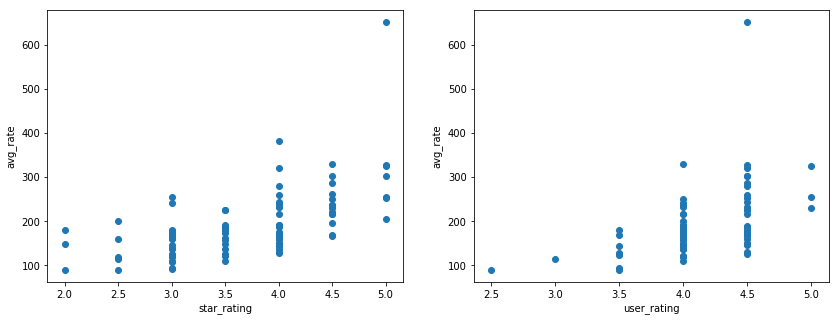

In [6]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.scatter(df_hotels['star_rating'].values, df_hotels['avg_rate'].values)
plt.xlabel('star_rating')
plt.ylabel('avg_rate')
plt.subplot(122)
plt.scatter(df_hotels['user_rating'].values, df_hotels['avg_rate'].values)
plt.xlabel('user_rating')
plt.ylabel('avg_rate')

## Content-based similarity

In [7]:
def get_hotel_recommendations(df, anchor_id):
    # features used to compute the similarity
    features = ['lat', 'lng', 'avg_rate', 'star_rating', 'user_rating']
    
    # create the features - make the anchor be the first row in the dataframe
    df_sorted = df.copy()
    df_sorted = pd.concat([df_sorted[df_sorted['hotel_id'] == anchor_id],
                           df_sorted[df_sorted['hotel_id'] != anchor_id]])
    df_features = df_sorted[features].copy()
    df_features = normalize_features(df_features)
    
    # compute the distances
    X = df_features.values
    Y = df_features.values[0].reshape(1, -1)
    distances = euclidean_distances(X, Y)
    
    df_sorted['similarity_distance'] = distances
    return df_sorted.sort_values('similarity_distance').reset_index(drop=True)


def normalize_features(df):
    for col in df.columns:
        # fill any NaN's with the mean
        df[col] = df[col].fillna(df[col].mean())
        df[col] = StandardScaler().fit_transform(df[col].values.reshape(-1, 1))
    return df

In [8]:
df_recs = get_hotel_recommendations(df_hotels, 10)

anchor_coords = (df_recs.loc[0, 'lat'], df_recs.loc[0, 'lng'])
df_recs['distance_from_anchor'] = df_recs.apply(
    lambda x: geodesic(anchor_coords, (x['lat'], x['lng'])).miles, axis=1)

df_recs.head(n=6)

,hotel_id,avg_rate,distance,star_rating,user_rating,lat,lng,similarity_distance,distance_from_anchor
0,10,326.40,0.535227,5.0,4.5,40.714995,-74.015777,0.000000,0.000000
1,59,300.99,0.691381,4.5,4.5,40.722772,-74.004714,1.275325,0.790763
2,16,285.00,0.533470,4.5,4.5,40.705176,-74.007686,1.294851,0.799728
3,31,319.67,0.247007,4.0,4.5,40.715250,-74.009430,1.472277,0.333713
4,23,324.99,0.115349,5.0,5.0,40.711220,-74.006719,1.522260,0.542236
5,80,252.33,0.541217,5.0,4.5,40.719263,-74.000160,1.569779,0.871232


In [9]:
df_recs = get_hotel_recommendations(df_hotels, 21)

anchor_coords = (df_recs.loc[0, 'lat'], df_recs.loc[0, 'lng'])
df_recs['distance_from_anchor'] = df_recs.apply(
    lambda x: geodesic(anchor_coords, (x['lat'], x['lng'])).miles, axis=1)

df_recs.head(n=6)

,hotel_id,avg_rate,distance,star_rating,user_rating,lat,lng,similarity_distance,distance_from_anchor
0,21,137.28,1.784900,3.5,4.0,40.723719,-74.036820,0.000000,0.000000
1,5,158.33,1.597422,2.5,4.0,40.721019,-74.034444,1.440670,0.224229
2,58,240.67,1.791967,3.0,4.0,40.727368,-74.034257,1.566769,0.285497
3,70,179.00,1.480134,3.0,4.5,40.715879,-74.033899,1.711905,0.562272
4,57,157.72,0.430344,3.5,4.0,40.709374,-74.012849,2.121175,1.601149
5,40,165.67,0.537491,4.0,4.0,40.708231,-74.014291,2.200945,1.594113


## Personalized recommendations

In [10]:
def get_personalized_hotel_recommendations(df, user_features):
    # features used to compute the similarity
    features = ['distance', 'avg_rate', 'star_rating', 'user_rating']
    
    # create the features
    df_features = df[features].copy()
    df_features = normalize_features(df_features)
    
    # artifically set the distance of the user anchor to be the min of the
    # normalized distance
    user_features['distance'] = df_features['distance'].min()
    df_user = pd.DataFrame([user_features])
    df_features = pd.concat([df_user, df_features], sort=False)
    
    # compute the distances
    X = df_features.values
    Y = df_features.values[0].reshape(1, -1)
    distances = euclidean_distances(X, Y)
    
    df_sorted = df.copy()
    df_sorted['similarity_distance'] = distances[1:]
    return df_sorted.sort_values('similarity_distance').reset_index(drop=True)

In [11]:
user_features = {
    'avg_rate': 0,
    'star_rating': 0,
    'user_rating': 0
}

df_recs = get_personalized_hotel_recommendations(df_hotels, user_features)
df_recs.head()

,hotel_id,avg_rate,distance,star_rating,user_rating,lat,lng,similarity_distance
0,55,179.00,0.315587,3.5,4.0,40.708914,-74.009169,0.543575
1,28,166.32,0.245397,4.0,NaN,40.709930,-74.008760,0.556512
2,82,191.03,0.258713,4.0,4.0,40.711213,-74.010464,0.577825
3,52,179.00,0.485230,3.5,NaN,40.705801,-74.005099,0.592224
4,3,159.21,0.244390,4.0,4.0,40.715570,-74.008901,0.707354


In [12]:
user_features = {
    'avg_rate': 1,
    'star_rating': 1,
    'user_rating': 1
}

df_recs = get_personalized_hotel_recommendations(df_hotels, user_features)
df_recs.head()

,hotel_id,avg_rate,distance,star_rating,user_rating,lat,lng,similarity_distance
0,16,285.00,0.533470,4.5,4.5,40.705176,-74.007686,0.626433
1,47,231.00,0.343481,4.0,4.5,40.708010,-74.007780,0.808889
2,65,242.33,0.460271,4.0,4.5,40.706269,-74.007782,0.811713
3,59,300.99,0.691381,4.5,4.5,40.722772,-74.004714,0.909595
4,31,319.67,0.247007,4.0,4.5,40.715250,-74.009430,0.929464
